In [1]:
import numpy as np
import pandas as pd
import scikitplot as skplt
import joblib

from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict, train_test_split


In [2]:
df = pd.read_csv('./german_credit_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [4]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [5]:
categories = df['Risk'].value_counts()

<AxesSubplot:title={'center':'Klasy'}, ylabel='Liczebność klasy'>

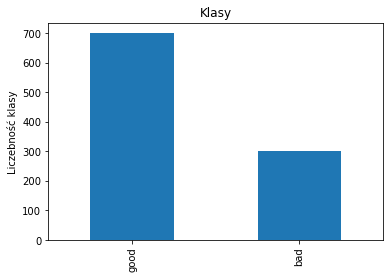

In [6]:
categories.plot.bar(ylabel='Liczebność klasy', title='Klasy')

In [7]:
if 'Unnamed: 0' in df: del df['Unnamed: 0']

In [8]:
df = pd.concat([df, pd.get_dummies(df.Sex, prefix='Sex')], axis=1)
df = pd.concat([df, pd.get_dummies(df.Purpose, prefix='Purpose')], axis=1)
df = df.rename(columns = {'Credit amount':'Credit_amount','Purpose_business':'P_buisness', 'Purpose_car':'P_car', 'Purpose_domestic appliances':'P_domestic_appliances', 'Purpose_education':'P_education', 'Purpose_furniture/equipment':'P_furniture_equipment', 'Purpose_radio/TV':'P_radio_TV', 'Purpose_repairs':'P_repairs', 'Purpose_vacation/others':'P_vacation_others'})

In [9]:
def house(row):
    if row['Housing'] == 'free': return 0
    elif row['Housing'] == 'rent': return 1
    else: return 2
df['House'] = df[['Housing']].apply(house, axis=1)

def savings(row):
    if row['Saving accounts'] == 'little': return 1
    elif row['Saving accounts'] == 'moderate': return 2
    elif row['Saving accounts'] == 'quite rich': return 3
    elif row['Saving accounts'] == 'rich': return 4
    else: return 0
df['Savings'] = df[['Saving accounts']].apply(savings, axis=1)

def checking_acc(row):
    if row['Checking account'] == 'little': return 1
    elif row['Checking account'] == 'moderate': return 2
    elif row['Checking account'] == 'rich': return 3
    else: return 0
df['Checking_acc'] = df[['Checking account']].apply(checking_acc, axis=1)

def category(row):
    if row['Risk'] == 'bad': return 1 
    else: return 0
df['Class'] = df[['Risk']].apply(category, axis=1)

In [10]:
df.sample(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit_amount,Duration,Purpose,Risk,...,P_domestic_appliances,P_education,P_furniture_equipment,P_radio_TV,P_repairs,P_vacation_others,House,Savings,Checking_acc,Class
369,40,female,2,rent,little,moderate,3001,18,furniture/equipment,good,...,0,0,1,0,0,0,1,1,2,0
875,40,female,2,own,rich,moderate,1322,11,car,good,...,0,0,0,0,0,0,2,4,2,0
560,49,male,2,free,NaN,little,2964,24,car,good,...,0,0,0,0,0,0,0,0,1,0
590,58,female,1,own,little,little,385,12,radio/TV,good,...,0,0,0,1,0,0,2,1,1,0
138,35,male,2,own,NaN,moderate,2728,15,radio/TV,good,...,0,0,0,1,0,0,2,0,2,0


### Przygotowanie modelu

In [52]:
def get_attributes(df, black_list=['Class']):
    num_attr = df.select_dtypes(np.number).columns
    return [i for i in num_attr if i not in black_list]
attributes = get_attributes(df)

def get_X_y(df, attributes=None):
    if attributes is None:
        attributes = get_attributes(df)
        
    X = df[attributes].values
    y = df['Class'].values
    
    return X, y

X, y = get_X_y(df)

In [53]:
print('Cechy wykorzystywane w modelu: \n', attributes)
# print('Macierz cech: \n', X)
# print('Wektor klas: \n', y)

Cechy wykorzystywane w modelu: 
 ['Age', 'Job', 'Credit_amount', 'Duration', 'Sex_female', 'Sex_male', 'P_buisness', 'P_car', 'P_domestic_appliances', 'P_education', 'P_furniture_equipment', 'P_radio_TV', 'P_repairs', 'P_vacation_others', 'House', 'Savings', 'Checking_acc']


In [54]:
# model = RandomForestClassifier()
# model.fit(X,y)
# y_pred = model.predict(X)
# skplt.metrics.plot_confusion_matrix(y_true=y, y_pred=y_pred)
# print(metrics.classification_report(y_true=y, y_pred=y_pred))

In [55]:
def macierz_raport(model, X, y):
    y_pred = cross_val_predict(model, X, y, cv=5)
    skplt.metrics.plot_confusion_matrix(y_true=y, y_pred=y_pred)
    raport = metrics.classification_report(y_true=y, y_pred=y_pred)
    print(raport) 

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       700
           1       0.58      0.39      0.46       300

    accuracy                           0.73      1000
   macro avg       0.67      0.63      0.64      1000
weighted avg       0.71      0.73      0.71      1000



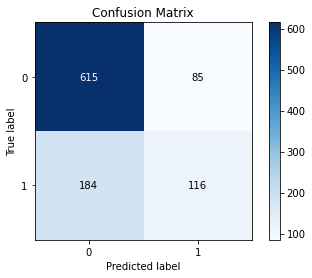

In [56]:
model_RandomForest = RandomForestClassifier()
cv = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)   
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model_RandomForest.fit(X_train, y_train)
    predicted_values = model_RandomForest.predict(X_test)
    
macierz_raport(model_RandomForest , X, y)

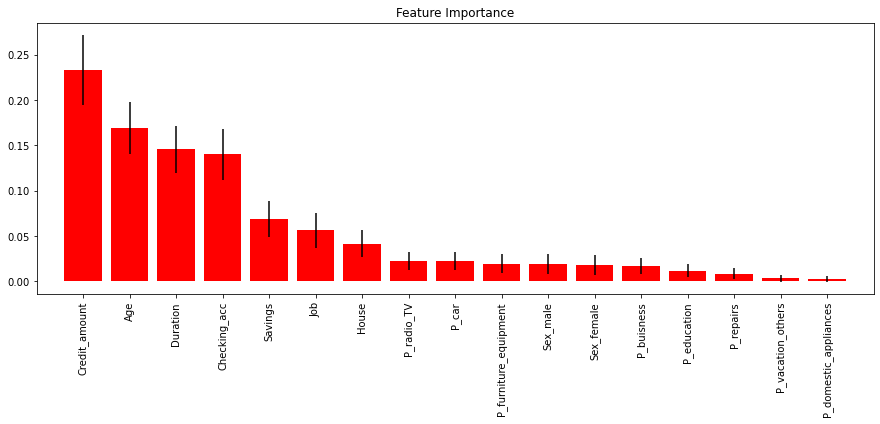

In [57]:
skplt.estimators.plot_feature_importances(model_RandomForest, feature_names=attributes, x_tick_rotation=90, figsize=(15, 5));

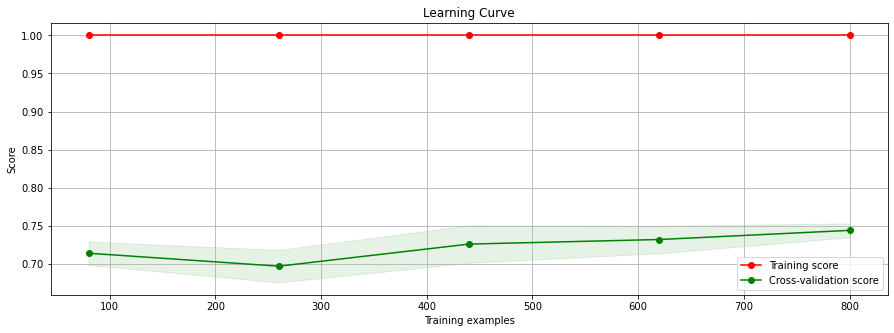

In [58]:
skplt.estimators.plot_learning_curve(model_RandomForest, X, y, cv=5, figsize=(15, 5), scoring='accuracy');

In [59]:
joblib.dump(model_RandomForest, './random_forest_cross.pkl')

['./random_forest_cross.pkl']

In [60]:
model = joblib.load('./random_forest_cross.pkl')

In [77]:
model.predict([[22,2,5951,48,1,0,0,0,0,0,0,1,0,0,2,1,2]])

array([1], dtype=int64)

In [78]:
def get_pred(Age=None, Job=None, Credit_amount=None, Duration=None, Sex_female=None, Sex_male=None, P_business=None, P_car=None, P_domestic_appliances=None, P_education=None, P_furniture_equipment=None, P_radio_TV=None, P_repairs=None, P_vacation_others=None, House=None, Savings=None, Checking_acc=None):
    model = joblib.load('./random_forest_cross.pkl')
    y_pred = model.predict( [[Age, Job, Credit_amount, Duration, Sex_female, Sex_male, P_business, P_car, P_domestic_appliances, P_education, P_furniture_equipment, P_radio_TV, P_repairs, P_vacation_others, House, Savings, Checking_acc]] )
    return y_pred

In [79]:
get_pred(22,2,5951,48,1,0,0,0,0,0,0,1,0,0,2,1,2)

array([1], dtype=int64)

In [85]:
%%writefile credit_server.py

import joblib
from flask import Flask, request, jsonify, render_template, escape
app = Flask(__name__)

def get_pred(Age=None, Job=None, Credit_amount=None, Duration=None, Sex_female=None, Sex_male=None, 
             P_business=None, P_car=None, P_domestic_appliances=None, P_education=None, P_furniture_equipment=None, 
             P_radio_TV=None, P_repairs=None, P_vacation_others=None, House=None, Savings=None, Checking_acc=None):
    model = joblib.load('./random_forest_cross.pkl')
    y_pred = model.predict([[Age, Job, Credit_amount, Duration, Sex_female, Sex_male, P_business, P_car, 
                              P_domestic_appliances, P_education, P_furniture_equipment, P_radio_TV, P_repairs, 
                              P_vacation_others, House, Savings, Checking_acc]])
    return y_pred


@app.route('/', methods=['GET', 'POST'])
def upload_data():
    if request.method == 'POST':
        print("IN")
        print(request.values)
        Age = request.values['Age']
        Job = int(request.values['Job'])
        Credit_amount = request.values['Credit_amount']
        Duration = request.values['Duration']
        Sex_female = 1 if request.values['Sex'] == 'F' else 0
        Sex_male = 1 if request.values['Sex'] == 'M' else 0
        P_business = 1 if request.values['Purpose'] == 'business' else 0
        P_car = 1 if request.values['Purpose'] == 'car' else 0
        P_domestic_appliances = 1 if request.values['Purpose'] == 'domestic_appliances' else 0
        P_education = 1 if request.values['Purpose'] == 'education' else 0
        P_furniture_equipment = 1 if request.values['Purpose'] == 'furniture_equipment' else 0
        P_radio_TV = 1 if request.values['Purpose'] == 'radio_TV' else 0
        P_repairs = 1 if request.values['Purpose'] == 'repairs' else 0
        P_vacation_others = 1 if request.values['Purpose'] == 'vacation_others' else 0
        House = int(request.values['House'])
        Savings = int(request.values['Savings'])
        Checking_acc = int(request.values['Checking_acc'])
        result = get_pred(Age, Job, Credit_amount, Duration, Sex_female, Sex_male, P_business, 
                              P_car, P_domestic_appliances, P_education, P_furniture_equipment, P_radio_TV, 
                              P_repairs, P_vacation_others, House, Savings, Checking_acc)
        label_pred = "Bad" if result == 1 else "Good"
        
        return '''
        <!doctype html>
        <title>Credit risk classification</title>
        <h1>Credit risk</h1>
        <p>Prediction result</p> 
        <p>Credit risk: {} </p>
        '''.format(escape(label_pred))
    
    return '''
    <!doctype html>
    <title>Credit risk classification</title>
    <h1>Credit risk classification</h1>
    <p>Enter data to predict credit risk</p>
    <form method=post enctype=multipart/form-data>
      <p><label>Credit amount</label><BR><input type="text" name="Credit_amount"/>
      <p><label>Duration in months</label><BR><input type="text" name="Duration"/>
      <p><label>Age</label><BR><input type="text" name="Age"/>
      <p><label>Sex</label><BR><input type="radio" name="Sex" value="F"/>female
      <input type="radio" name="Sex" value="M"/>male
      <p><label>Purpose</label><BR><input type="radio" name="Purpose" value="business"/>business
      <input type="radio" name="Purpose" value="car"/>car
      <input type="radio" name="Purpose" value="education"/>education
      <input type="radio" name="Purpose" value="domestic_appliances"/>domestic appliances
      <input type="radio" name="Purpose" value="repairs"/>repairs
      <input type="radio" name="Purpose" value="furniture_equipment"/>furniture/equipment
      <input type="radio" name="Purpose" value="radio_TV"/>radio/TV
      <input type="radio" name="Purpose" value="vacation_others"/>vacation/others
      <p><label>Job</label><BR><input type="radio" name="Job" value="0"/>unskilled and non-resident
      <input type="radio" name="Job" value="1"/>unskilled and resident
      <input type="radio" name="Job" value="2"/>skilled
      <input type="radio" name="Job" value="3"/>highly skilled
      <p><label>House</label><BR><input type="radio" name="House" value="0"/>free
      <input type="radio" name="House" value="1"/>rent
      <input type="radio" name="House" value="2"/>own
      <p><label>Checking account</label><BR><input type="radio" name="Checking_acc" value="1"/>little
      <input type="radio" name="Checking_acc" value="2"/>moderate
      <input type="radio" name="Checking_acc" value="3"/>rich
      <p><label>Savings</label><BR><input type="radio" name="Savings" value="1"/>little
      <input type="radio" name="Savings" value="2"/>moderate
      <input type="radio" name="Savings" value="3"/>quite rich
      <input type="radio" name="Savings" value="4"/>rich  
      <p><input type=submit value="Submit"><BR>
      <p><input type="reset" value="Reset">
    </form>
    '''


Overwriting credit_server.py


In [65]:
PORT=5000
HOST='0.0.0.0' 

In [68]:
# set FLASK_APP=credit_server.py
# flask run --port "5000" --host "0.0.0.0"

In [84]:
!FLASK_APP=credit_server.py flask run --port "$PORT" --host "$HOST"

'FLASK_APP' is not recognized as an internal or external command,
operable program or batch file.


### Prediction app view 

<img src="./picture_1.png">

<img src="./picture_2.png">